# Creación de indicadores técnicos

In [14]:
import numpy as np
import pandas as pd

def make_tech_indicators(
    data,
    price_col: str = "Close",
    high_col: str = "High",
    low_col: str = "Low",
    vol_col: str = "Volume",
    safe: bool = True,          # anti-fuga: shift(1) de todos los features
    reset_index: bool = True    # agrega columna Date en vez de dejar índice datetime
) -> pd.DataFrame:
    """
    Dada una serie temporal (pd.Series con precios o pd.DataFrame OHLCV),
    retorna un DataFrame con columnas: Date, Price, <indicadores...>.
    Los indicadores que requieren High/Low/Volume solo se calculan si existen.

    Reglas:
    - Todos los features quedan calculados en t con info hasta t, y si safe=True se desplazan 1 paso para predecir t+1.
    - Tipos float64 y np.nan (no pd.NA) para que no reviente rolling().
    """

    # ---------- Normalización de entrada ----------
    if isinstance(data, pd.Series):
        df = data.to_frame(name=price_col).copy()
    else:
        df = data.copy()

    if df.index.name is None:
        df.index.name = "Date"
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Asegura columnas esperadas y dtypes
    for c in [price_col, high_col, low_col, vol_col]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")
    if price_col not in df.columns:
        raise ValueError(f"Falta columna de precio '{price_col}'")

    has_hl = high_col in df.columns and low_col in df.columns
    has_vol = vol_col in df.columns

    # Alias locales
    close = df[price_col]
    high  = df[high_col] if has_hl else None
    low   = df[low_col]  if has_hl else None
    vol   = df[vol_col].replace(0, np.nan).astype("float64") if has_vol else None

    # ---------- Helpers internos ----------
    ema = lambda s, span: s.ewm(span=span, adjust=False).mean()

    def true_range():
        prev_close = close.shift(1)
        tr1 = (high - low) if has_hl else (close - close) * np.nan
        tr2 = (high - prev_close).abs() if has_hl else (close - prev_close).abs()
        tr3 = (low - prev_close).abs() if has_hl else (prev_close - close).abs()
        return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    def rsi(n=14):
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        return (100 - (100 / (1 + rs))).fillna(50.0)

    def stochastic(n=14, d=3):
        if not has_hl:
            return pd.Series(np.nan, index=df.index), pd.Series(np.nan, index=df.index)
        low_n = low.rolling(n).min()
        high_n = high.rolling(n).max()
        k = 100 * (close - low_n) / (high_n - low_n)
        dline = k.rolling(d).mean()
        return k, dline

    def bollinger(n=20, k=2):
        ma = close.rolling(n).mean()
        sd = close.rolling(n).std()
        upper, lower = ma + k*sd, ma - k*sd
        bw = (upper - lower) / ma
        pb = (close - lower) / (upper - lower)
        return bw, pb

    def adx_block(n=14):
        if not has_hl:
            nan = pd.Series(np.nan, index=df.index)
            return nan, nan, nan, nan
        up_move = high.diff()
        down_move = -low.diff()
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
        tr = true_range()
        atr = tr.ewm(alpha=1/n, adjust=False).mean()
        plus_di = 100 * pd.Series(plus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        minus_di = 100 * pd.Series(minus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
        adx = dx.ewm(alpha=1/n, adjust=False).mean()
        return atr, adx, plus_di, minus_di

    def obv():
        if not has_vol:
            return pd.Series(np.nan, index=df.index)
        return (np.sign(close.diff()).fillna(0) * vol.fillna(0)).cumsum()

    def mfi(n=14):
        if not (has_hl and has_vol):
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        mf = tp * vol.fillna(0.0)
        pos_flow = np.where(tp > tp.shift(1), mf, 0.0)
        neg_flow = np.where(tp < tp.shift(1), mf, 0.0)
        pos = pd.Series(pos_flow, index=df.index, dtype="float64").rolling(n).sum()
        neg = pd.Series(neg_flow, index=df.index, dtype="float64").rolling(n).sum()
        mfr = pos / neg.replace(0, np.nan)
        return (100 - (100 / (1 + mfr))).fillna(50.0)

    def cci(n=20):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        sma = tp.rolling(n).mean()
        mad = (tp - sma).abs().rolling(n).mean()
        return (tp - sma) / (0.015 * mad)

    def williams_r(n=14):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        hh = high.rolling(n).max()
        ll = low.rolling(n).min()
        denom = (hh - ll).replace(0, np.nan)
        return -100 * (hh - close) / denom

    # ---------- Cálculo de indicadores ----------
    out = pd.DataFrame(index=df.index)
    out["Price"] = close.astype("float64")
    
    out["Open"] = df["Open"].astype("float64") if "Open" in df.columns else np.nan
    out["High"] = high if has_hl else np.nan
    out["Low"] = low if has_hl else np.nan
    out["Volume"] = df[vol_col] if has_vol else np.nan

    # Tendencia
    for n in [5, 10, 20, 50, 200]:
        out[f"SMA_{n}"] = close.rolling(n).mean()
    for n in [5, 10, 20, 50]:
        out[f"EMA_{n}"] = ema(close, n)

    macd = ema(close, 12) - ema(close, 26)
    macd_sig = ema(macd, 9)
    out["MACD"] = macd
    out["MACD_signal"] = macd_sig
    out["MACD_hist"] = macd - macd_sig

    # Momentum
    for h in [1, 5, 10]:
        out[f"ROC_{h}"] = (close - close.shift(h)) / close.shift(h)
        out[f"MOM_{h}"] = close - close.shift(h)
    out["RSI_14"] = rsi(14)

    # Volatilidad y bandas
    out["VOL_20"] = np.log(close / close.shift(1)).rolling(20).std()
    bw, pb = bollinger(20, 2)
    out["BB_BW"] = bw
    out["BB_PB"] = pb

    # Osciladores con H/L
    k, d = stochastic(14, 3)
    out["STOCH_K"] = k
    out["STOCH_D"] = d
    out["WILLR_14"] = williams_r(14)
    out["CCI_20"] = cci(20)

    # Rango y dirección
    atr, adx, plus_di, minus_di = adx_block(14)
    out["ATR_14"] = atr
    out["ADX_14"] = adx
    out["PLUS_DI"] = plus_di
    out["MINUS_DI"] = minus_di

    # Flujo / volumen
    out["OBV"] = obv()
    out["MFI_14"] = mfi(14)

    # Extras livianos
    out["BIAS_12"] = (close - close.rolling(12).mean()) / close.rolling(12).mean()
    updays = (close.diff() > 0).astype(int)
    out["PSY_12"] = 100 * updays.rolling(12).mean()
    # BBI (promedio SMA 3,6,12,24)
    out["BBI"] = (close.rolling(3).mean() + close.rolling(6).mean() +
                  close.rolling(12).mean() + close.rolling(24).mean()) / 4.0
    # CHO (Chaikin Oscillator)
    if has_hl and has_vol:
        clv = ((close - low) - (high - close)) / (high - low)
        clv = clv.replace([np.inf, -np.inf], np.nan).fillna(0)
        adl = (clv * vol.fillna(0)).cumsum()
        out["CHO_3_10"] = ema(adl, 3) - ema(adl, 10)
    else:
        out["CHO_3_10"] = np.nan

    # MASS / WVAD / AR-BR / CR (si hay H/L/V)
    if has_hl:
        diff_hl = (high - low).abs()
        e1 = diff_hl.ewm(span=9, adjust=False).mean()
        e2 = e1.ewm(span=9, adjust=False).mean()
        ratio = e1 / e2.replace(0, np.nan)
        out["MASS_25"] = ratio.rolling(25).sum()
    else:
        out["MASS_25"] = np.nan

    if has_hl and has_vol:
        rng = (high - low).replace(0, np.nan)
        out["WVAD_24"] = (((close - df.get("Open", close)) / rng) * vol).rolling(24).sum()

        ar_num = (high - df.get("Open", close)).rolling(26).sum()
        ar_den = (df.get("Open", close) - low).rolling(26).sum().replace(0, np.nan)
        out["AR_26"] = 100 * ar_num / ar_den

        cp = close.shift(1)
        br_num = (high - cp).rolling(26).sum()
        br_den = (cp - low).rolling(26).sum().replace(0, np.nan)
        out["BR_26"] = 100 * br_num / br_den

        mid = (high + low + 2*close) / 4
        mid_y = mid.shift(1)
        up = (high - mid_y).clip(lower=0)
        down = (mid_y - low).clip(lower=0)
        out["CR_26"] = 100 * up.rolling(26).sum() / down.rolling(26).sum().replace(0, np.nan)
    else:
        out["WVAD_24"] = np.nan
        out["AR_26"] = np.nan
        out["BR_26"] = np.nan
        out["CR_26"] = np.nan

    # ---------- Anti-fuga ----------
    if safe:
        feat_cols = [c for c in out.columns if c != "Price"]
        out[feat_cols] = out[feat_cols].shift(1)

    # ---------- Limpieza ----------
    out = out.astype("float64")
    out = out.dropna().copy()

    if reset_index:
        out = out.rename_axis("Date").reset_index()

    return out



| **Indicador** | **Fórmula** | **Descripción / Interpretación** |
|----------------|-------------|----------------------------------|
| **SMA (Simple Moving Average)** | $ SMA_t = \frac{1}{n}\sum_{i=0}^{n-1} P_{t-i} $ | Promedio simple de precios. Suaviza ruido y muestra tendencia general. |
| **EMA (Exponential Moving Average)** | $ EMA_t = \alpha P_t + (1-\alpha) EMA_{t-1}, \ \alpha = \frac{2}{n+1} $ | Promedio ponderado que da más importancia a precios recientes. |
| **MACD (Moving Average Convergence Divergence)** | $ MACD_t = EMA_{12} - EMA_{26}, \ Signal_t = EMA_9(MACD_t) $ | Mide convergencia/divergencia entre medias móviles; cruces indican cambios de tendencia. |
| **ROC (Rate of Change)** | $ ROC_t = \frac{P_t - P_{t-n}}{P_{t-n}} $ | Tasa de cambio porcentual del precio; mide momentum relativo. |
| **MOM (Momentum)** | $ MOM_t = P_t - P_{t-n} $ | Diferencia absoluta del precio en $n$ periodos; fuerza del movimiento. |
| **RSI (Relative Strength Index)** | $ RSI_t = 100 - \frac{100}{1 + RS}, \ RS = \frac{\text{promedio ganancias}}{\text{promedio pérdidas}} $ | Oscilador 0–100; sobrecompra >70, sobreventa <30. |
| **PSY (Psychological Line)** | $ PSY_t = 100 \times \frac{\#(P_t > P_{t-1})}{n} $ | Porcentaje de días con cierre al alza; mide sentimiento del mercado. |
| **VOL (Volatilidad 20d)** | $ VOL_t = \sigma\left(\ln\frac{P_t}{P_{t-1}}\right)_{20} $ | Desviación estándar de los retornos logarítmicos a 20 días. |
| **Bollinger Bands (BW, PB)** | $ BW = \frac{U-L}{MA}, \ PB = \frac{P-L}{U-L}, \ U=MA+k\sigma, L=MA-k\sigma $ | Ancho de banda (volatilidad) y posición del precio dentro del canal. |
| **Stochastic Oscillator (K, D)** | $ \%K = 100\frac{P - L_n}{H_n - L_n}, \%D = SMA_3(\%K) $ | Relación del cierre actual con el rango de precios reciente; detecta extremos. |
| **Williams %R** | $ \%R = -100\frac{H_n - P}{H_n - L_n} $ | Similar al Stochastic; sobrecompra/sobreventa. |
| **CCI (Commodity Channel Index)** | $ CCI = \frac{TP - SMA(TP)}{0.015 \times MAD(TP)}, \ TP=\frac{H+L+C}{3} $ | Mide la desviación del precio respecto a su promedio típico. |
| **ATR (Average True Range)** | $ ATR = EMA(TR), \ TR=\max(H-L, |H-C_{t-1}|, |L-C_{t-1}|) $ | Volatilidad “real” considerando huecos (gaps). |
| **ADX (Average Directional Index)** | $ ADX = EMA\left(100\frac{|+DI - -DI|}{+DI + -DI}\right) $ | Mide la fuerza de la tendencia (sin dirección). |
| **+DI / -DI (Directional Indicators)** | $ +DI = 100\frac{EMA(+DM)}{ATR}, \ -DI = 100\frac{EMA(-DM)}{ATR} $ | Miden presión compradora (+DI) o vendedora (-DI). |
| **OBV (On-Balance Volume)** | $ OBV_t = OBV_{t-1} + \text{sign}(P_t - P_{t-1})V_t $ | Acumula volumen según dirección del precio; confirma tendencias. |
| **MFI (Money Flow Index)** | $ MFI = 100 - \frac{100}{1 + \frac{\sum MF^+}{\sum MF^-}} $, $ MF=TP\times V $ | RSI ponderado por volumen; mide flujo de dinero. |
| **BIAS** | $ BIAS = \frac{P - SMA_n(P)}{SMA_n(P)} $ | Desviación porcentual del precio respecto a su media. |
| **BBI (Bull and Bear Index)** | $ BBI = \frac{SMA_3 + SMA_6 + SMA_{12} + SMA_{24}}{4} $ | Promedio de 4 SMAs; muestra tendencia de medio plazo. |
| **CHO (Chaikin Oscillator)** | $ CHO = EMA_3(ADL) - EMA_{10}(ADL), \ ADL = \sum (CLV \times V) $ | Detecta acumulación/distribución mediante volumen y rango. |
| **MASS Index** | $ MASS = \sum_{i=0}^{25} \frac{EMA_9(H-L)}{EMA_9(EMA_9(H-L))} $ | Detecta posibles reversiones de tendencia por expansión del rango. |
| **WVAD (Williams Variable A/D)** | $ WVAD = \sum \frac{(C - O)}{H - L} \times V $ | Mide presión de compra/venta combinando rango y volumen. |
| **AR** | $ AR = 100 \frac{\sum(H - O)}{\sum(O - L)} $ | Evalúa fuerza interna de compradores vs. vendedores. |
| **BR** | $ BR = 100 \frac{\sum(H - C_{t-1})}{\sum(C_{t-1} - L)} $ | Evalúa fuerza externa de reacción del mercado. |
| **CR (Energy Index)** | $ CR = 100 \frac{\sum(H - MID_{t-1})}{\sum(MID_{t-1} - L)} $, $ MID=\frac{H+L+2C}{4} $ | Variante que mide presión compradora mediante media desplazada. |

---

### 🧠 Notas
- Todos los indicadores se **desplazan 1 paso (`shift(1)`)** cuando `safe=True`, para evitar fuga temporal.  
- Los que requieren `High`, `Low` o `Volume` devuelven `NaN` si faltan esas columnas.  
- Los primeros valores se pierden por ventanas de cálculo (`rolling`, `EMA`).  
- Todos los resultados son `float64` y listos para modelado o análisis.

In [ ]:
# Caso Kaggle OHLCV (DataFrame con Date indexado)

df = pd.read_csv("Dataset/Stocks/aapl.us.txt")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()


df = make_tech_indicators(df, price_col="Close", high_col="High", low_col="Low", vol_col="Volume")




# Algoritmo Genético

In [16]:
# === GA para selección de features con series de tiempo ===
# Requisitos: numpy, pandas, scikit-learn
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from dataclasses import dataclass


In [17]:
# ----------------------------------------------------------
# Utilidades
# ----------------------------------------------------------
def _rmse(y_true, y_pred):
    e = y_true - y_pred
    return float(np.sqrt(np.mean(e**2)))

def evaluar_subset_TS(X: pd.DataFrame, y: pd.Series, mask: np.ndarray, n_splits=5) -> float:
    """
    Evalúa un subconjunto de columnas (mask booleana) con Ridge + escalado,
    usando TimeSeriesSplit. Devuelve fitness = 1/(1+RMSE_prom).
    Si el subset es vacío o casi vacío, aplica una penalización.
    """
    sel_cols = X.columns[mask]
    if len(sel_cols) < 3:  # penaliza cromosomas raquíticos
        return 1e-6

    Xs = X[sel_cols].values
    ys = y.values

    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    modelo = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("reg", Ridge(alpha=1.0, random_state=0))
    ])

    rmses = []
    for tr_idx, te_idx in tscv.split(Xs):
        Xtr, Xte = Xs[tr_idx], Xs[te_idx]
        ytr, yte = ys[tr_idx], ys[te_idx]
        # anti-leak implícito: el split respeta el tiempo y el scaler se ajusta SOLO en train
        modelo.fit(Xtr, ytr)
        pr = modelo.predict(Xte) # Con lo aprendido en train se predice test
        rmses.append(_rmse(yte, pr)) # calcula RMSE para este split

    rmse_prom = np.mean(rmses) if rmses else 1e9
    fitness = 1.0 / (1.0 + rmse_prom)
    if not np.isfinite(fitness) or fitness <= 0:
        fitness = 1e-9
    return float(fitness)

def _multipoint_crossover(p1: np.ndarray, p2: np.ndarray, n_points=2):
    """
    Cruce multipunto: corta y alterna segmentos.
    """
    L = len(p1)
    if L < 2: 
        return p1.copy(), p2.copy()
    # puntos de corte únicos entre 1 y L-1
    pts = np.sort(np.random.choice(np.arange(1, L), size=min(n_points, max(1, L-1)), replace=False))
    child1, child2 = p1.copy(), p2.copy()
    swap = False
    last = 0
    for pt in list(pts) + [L]:
        if swap:
            child1[last:pt], child2[last:pt] = p2[last:pt], p1[last:pt]
        last = pt
        swap = not swap
    return child1, child2

def _bitflip_mutation(ind: np.ndarray, p=0.003):
    flips = np.random.rand(ind.size) < p
    ind[flips] = ~ind[flips]
    return ind

def _ensure_min_features(ind: np.ndarray, kmin=3):
    # Si hay menos de kmin bits en 1, enciende aleatorios
    on = ind.sum()
    if on < kmin:
        idx0 = np.where(~ind)[0]
        if idx0.size > 0:
            turn_on = np.random.choice(idx0, size=min(kmin-on, idx0.size), replace=False)
            ind[turn_on] = True
    return ind

@dataclass
class GAConfig:
    pop_size: int = 100
    p_crossover: float = 0.8
    p_mutation: float = 0.003
    generations: int = 100
    n_points_cx: int = 2
    elitism: int = 2
    min_features: int = 3
    n_splits_cv: int = 5
    random_state: int = 42

class GASelector:
    def __init__(self, X: pd.DataFrame, y: pd.Series, cfg: GAConfig):
        self.X = X
        self.y = y
        self.cfg = cfg
        np.random.seed(cfg.random_state)
        self.n_feat = X.shape[1]
        # población booleana inicial ~50% activos
        self.pop = np.random.rand(cfg.pop_size, self.n_feat) < 0.5
        for i in range(cfg.pop_size):
            self.pop[i] = _ensure_min_features(self.pop[i], cfg.min_features)

        self.history_best = []   # (gen, fitness, mask)
        self.history_scores = [] # lista fitness por generación

    def _fitness_all(self, pop):
        fits = np.zeros(pop.shape[0], dtype=float)
        for i, mask in enumerate(pop):
            fits[i] = evaluar_subset_TS(self.X, self.y, mask, n_splits=self.cfg.n_splits_cv)
        return fits

    def _roulette_select(self, fits, k):
        # probabilidades proporcionales al fitness, con epsilon por si acaso
        f = np.array(fits, dtype=float)
        f = f - f.min() + 1e-12
        p = f / f.sum() if f.sum() > 0 else np.ones_like(f) / len(f)
        idx = np.random.choice(len(f), size=k, replace=True, p=p)
        return idx

    def run(self):
        cfg = self.cfg
        pop = self.pop.copy()
        for gen in range(cfg.generations):
            fits = self._fitness_all(pop)
            self.history_scores.append(fits)

            # guarda mejor de la generación
            ibest = int(np.argmax(fits))
            self.history_best.append((gen, float(fits[ibest]), pop[ibest].copy()))

            # ELITISMO
            elite_idx = np.argsort(-fits)[:cfg.elitism]
            elites = pop[elite_idx].copy()

            # SELECCIÓN por ruleta para padres
            parent_idx = self._roulette_select(fits, cfg.pop_size)
            parents = pop[parent_idx]

            # CRUCE
            next_pop = []
            for i in range(0, cfg.pop_size, 2):
                p1 = parents[i].copy()
                p2 = parents[i+1].copy() if i+1 < cfg.pop_size else parents[0].copy()
                if np.random.rand() < cfg.p_crossover:
                    c1, c2 = _multipoint_crossover(p1, p2, n_points=cfg.n_points_cx)
                else:
                    c1, c2 = p1, p2
                # MUTACIÓN
                c1 = _bitflip_mutation(c1, cfg.p_mutation)
                c2 = _bitflip_mutation(c2, cfg.p_mutation)
                # mínimo de features
                c1 = _ensure_min_features(c1, cfg.min_features)
                c2 = _ensure_min_features(c2, cfg.min_features)
                next_pop.append(c1); next_pop.append(c2)

            pop = np.array(next_pop[:cfg.pop_size], dtype=bool)

            # reemplaza peores por elites
            if cfg.elitism > 0:
                # mete elites en posiciones aleatorias
                repl_idx = np.random.choice(cfg.pop_size, size=cfg.elitism, replace=False)
                pop[repl_idx] = elites

        self.pop = pop
        return self

    # Importancia por frecuencia: cuántas veces aparece cada feature en el mejor cromosoma de cada generación
    def feature_importance_frequency(self):
        masks = [m for _, _, m in self.history_best]
        freq = np.sum(np.vstack(masks), axis=0).astype(int)
        imp = pd.Series(freq, index=self.X.columns, name="freq_best_generations").sort_values(ascending=False)
        return imp

    def best_solution(self):
        # mejor en toda la corrida
        all_best = max(self.history_best, key=lambda t: t[1])
        gen, fit, mask = all_best
        cols = self.X.columns[mask]
        return {"generation": gen, "fitness": fit, "mask": mask, "features": list(cols)}

# ----------------------------------------------------------
# Ejemplo de uso con tus features técnicos
# ----------------------------------------------------------
# Suponiendo que ya tienes un DataFrame `feat` producido por make_tech_indicators(...)
# con columnas: ["Date", "Price", ...indicadores...]
def preparar_Xy_para_GA(features_df: pd.DataFrame):
    df = features_df.copy()
    if "Date" in df.columns:
        df = df.set_index("Date")
    # Target: retorno log de t+1
    df["ret_next"] = np.log(df["Price"].shift(-1) / df["Price"])
    df = df.dropna()
    y = df["ret_next"].astype(float)
    # X: todas las columnas excepto Price y target
    X = df.drop(columns=["ret_next", "Price"])
    # elimina columnas constantes por si acaso
    const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
    if const_cols:
        X = X.drop(columns=const_cols)
    return X, y

# ====== DEMO  ======
df_ohlcv = pd.read_csv("Dataset/Stocks/aapl.us.txt")
features = make_tech_indicators(df_ohlcv)  
X, y = preparar_Xy_para_GA(features)

cfg = GAConfig(
    pop_size=100,
    p_crossover=0.8,
    p_mutation=0.003,
    generations=100,
    n_points_cx=4,
    elitism=0,
    min_features=3,
    n_splits_cv=5,
    random_state=123
)
ga = GASelector(X, y, cfg).run()
ranking = ga.feature_importance_frequency()
best = ga.best_solution()

print("=== Mejor solución ===")
print(best["features"], "fitness:", best["fitness"], "gen:", best["generation"])
print("\n=== Ranking por frecuencia (top 15) ===")
print(ranking.head(15))

=== Mejor solución ===
['MACD_signal', 'ROC_5', 'ROC_10', 'RSI_14', 'BB_PB', 'STOCH_K', 'STOCH_D', 'WILLR_14', 'CCI_20', 'PLUS_DI', 'PSY_12', 'CHO_3_10'] fitness: 0.9732224150865951 gen: 48

=== Ranking por frecuencia (top 15) ===
PLUS_DI        97
MACD_signal    96
PSY_12         92
ROC_10         92
Volume         90
STOCH_K        90
EMA_20         86
CCI_20         86
STOCH_D        84
SMA_10         82
BB_PB          77
SMA_50         68
EMA_10         51
BBI            44
CR_26          40
Name: freq_best_generations, dtype: int64


## Resultados Algoritmo Genético

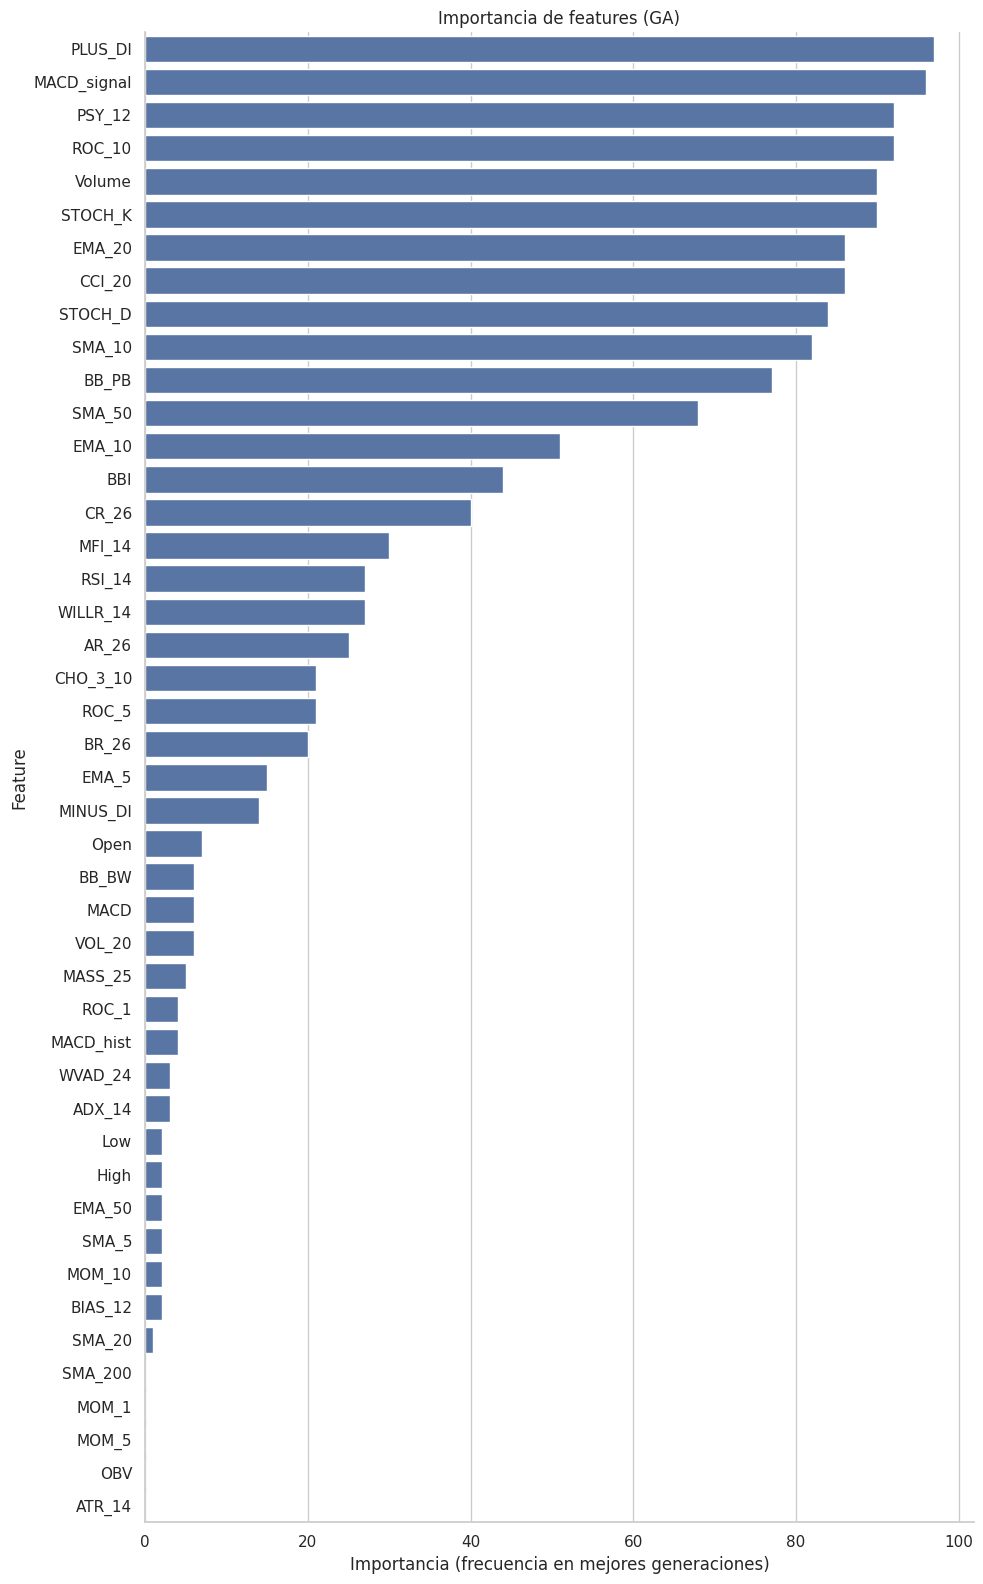

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# si vienes de feature_importance_frequency()
# ranking: pd.Series, name="freq_best_generations"

top_n = 46 # ajusta a gusto
plot_df = ranking.sort_values(ascending=False).head(top_n).reset_index()
plot_df.columns = ["feature", "importance"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, max(4, int(top_n*0.35))))
ax = sns.barplot(data=plot_df, x="importance", y="feature")
ax.set(
    title="Importancia de features (GA)",
    xlabel="Importancia (frecuencia en mejores generaciones)",
    ylabel="Feature"
)
sns.despine()
plt.tight_layout()
plt.show()
